In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import os

%matplotlib inline

In [5]:
data = pd.read_csv('all_outputs.csv')

## Looking at the raw data:

In [6]:
data.head()

,jj_m,reco_q_1,reco_q_2,reco_g_1,reco_g_2,jet_mom_1,jet_mom_2,jet_e_1,jet_e_2,jet_eta_1,jet_eta_2,jet_nchad_1,jet_nchad_2,jet_nconst_1,jet_nconst_2,label
0,122.086,0.122196,0.101619,0.699699,0.827713,48.4071,49.7014,68.7686,53.3260,1.127010,-1.113640,23,21,44,45,1
1,125.364,0.052471,0.485203,0.822686,0.394518,56.4287,55.8572,67.3314,58.0372,-0.966960,0.992363,20,12,50,24,1
2,123.899,0.116872,0.888024,0.292426,0.009174,59.8905,59.8366,63.0592,60.8402,0.683653,-0.681494,9,8,26,11,1
3,124.111,0.174939,0.041289,0.775762,0.834111,48.0868,48.4018,73.2336,50.8795,-0.100210,0.099877,20,14,55,33,1
4,125.215,0.002004,0.144856,0.073018,0.423673,59.0139,58.1796,65.8322,59.3867,1.172700,-1.163360,24,12,54,29,1


In [7]:
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

Size of data: (300000, 16)
Number of events: 300000
Number of columns: 16

List of features in dataset:
jj_m
reco_q_1
reco_q_2
reco_g_1
reco_g_2
jet_mom_1
jet_mom_2
jet_e_1
jet_e_2
jet_eta_1
jet_eta_2
jet_nchad_1
jet_nchad_2
jet_nconst_1
jet_nconst_2
label


In [8]:
print('Number of signal events: {}'.format(len(data[data.label == 1])))
print('Number of background events: {}'.format(len(data[data.label == 0])))
print('Fraction signal: {}'.format(len(data[data.label == 1])/(float)(len(data[data.label == 1]) + len(data[data.label == 0]))))

Number of signal events: 200000
Number of background events: 100000
Fraction signal: 0.6666666666666666


## Formatting the data for use with XGBoost

In [9]:
shuf_data = data.sample(frac=1)

In [10]:
shuf_data.head(10)

,jj_m,reco_q_1,reco_q_2,reco_g_1,reco_g_2,jet_mom_1,jet_mom_2,jet_e_1,jet_e_2,jet_eta_1,jet_eta_2,jet_nchad_1,jet_nchad_2,jet_nconst_1,jet_nconst_2,label
218861,113.557,0.000246,0.000080,0.005455,0.011362,49.4968,53.6474,58.4243,55.3325,0.971610,-1.136450,17,5,54,25,0
107319,124.570,0.049982,0.119362,0.883203,0.819427,56.5598,55.9043,65.6229,58.9491,1.389750,-1.400190,24,18,45,35,1
163159,114.145,0.320961,0.070624,0.438910,0.764539,57.7348,48.8888,60.2283,54.3357,-1.677260,1.480920,18,13,34,38,1
94653,122.828,0.026362,0.062462,0.903554,0.785424,41.9562,39.6678,80.4047,42.4444,-0.349916,0.354234,31,15,64,41,1
271313,123.299,0.580486,0.628581,0.204943,0.076041,51.8081,53.2065,69.5982,53.7140,-1.200890,1.241380,11,6,25,18,0
161810,109.218,0.169009,0.013145,0.712391,0.512396,50.0189,38.8825,55.1987,54.6450,2.210490,-1.889660,15,23,36,53,1
31603,124.645,0.726845,0.145135,0.263923,0.817664,55.3451,55.3263,62.9084,61.7363,1.095940,-1.100620,17,24,35,49,1
215636,125.238,0.000168,0.000058,0.025799,0.008187,55.9664,55.9209,68.6841,56.5536,-0.223289,0.221936,6,9,20,19,0
294008,125.668,0.000055,0.000140,0.004760,0.008161,57.1551,59.3019,65.7178,59.9700,-0.369035,0.360700,15,8,33,19,0
191184,125.574,0.289193,0.205078,0.286956,0.596685,54.8359,55.5015,65.6195,59.9585,-0.707788,0.719123,19,11,31,24,1


In [11]:
shuf_data['label'] = data.label.astype('category')

Taking 70% of data for training set, 15% for evaluation set, and 15% for test set.

In [12]:
no_events = shuf_data.shape[0]
no_training = int(0.7 * no_events)
no_eval = int(no_training + (0.15 * no_events))

training_set = shuf_data[:no_training]
evaluation_set = shuf_data[no_training:no_eval]
test_set = shuf_data[no_eval:]

In [13]:
print('Number of training samples: {}'.format(len(training_set)))
print('Number of evaluation samples: {}'.format(len(evaluation_set)))
print('Number of testing samples: {}'.format(len(test_set)))

print('\nNumber of signal events in training set: {}'.format(len(training_set[training_set.label == 1])))
print('Number of background events in training set: {}'.format(len(training_set[training_set.label == 0])))
print('Fraction signal: {}'.format(len(training_set[training_set.label == 1])/(float)(len(training_set[training_set.label == 1]) + len(training_set[training_set.label == 0]))))

Number of training samples: 210000
Number of evaluation samples: 45000
Number of testing samples: 45000

Number of signal events in training set: 140146
Number of background events in training set: 69854
Fraction signal: 0.6673619047619047


In [14]:
# training_set.label.cat.codes
# print(training_set.label.cat.codes)

## Creating DMatrix

In [15]:
feature_names = data.columns[0:-1]  # skip the final collumn as it is the label
# print(feature_names)
train = xgb.DMatrix(data=training_set[feature_names],label=training_set.label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
eval = xgb.DMatrix(data=evaluation_set[feature_names],label=evaluation_set.label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=test_set[feature_names],label=test_set.label.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [16]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of evaluation samples: {}'.format(eval.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of signal events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 210000
Number of evaluation samples: 45000
Number of testing samples: 45000

Number of signal events in training set: 140146


## Hyperparameters

## Evaluating Hyperparmameters

In [90]:
eta_range = np.arange(0.1, 0.9, 0.1)
max_depth_range = np.arange(2, 17, 1)
subsample_range = np.arange(0.1, 1.1, 0.1)
colsample_range = np.arange(0.1, 1.1, 0.1)
lambda_range = np.arange(0, 11, 1.0)
tree_range = np.arange(25, 325, 25)

rmse_outputs = np.zeros(len(tree_range))

print(tree_range)

[ 25  50  75 100 125 150 175 200 225 250 275 300]


In [91]:
## regex pattern to find floats in evaluator string
# float_pattern = r'\d+\.\d+'
#
# for i in range(len(tree_range)):
#     param = {}
#
#     # Booster parameters
#     param['eta']              = 0.3 # learning rate
#     param['max_depth']        = 6  # maximum depth of a tree
#     param['subsample']        = 1 # fraction of events to train tree on
#     param['colsample_bytree'] = 1 # fraction of features to train tree on
#
#     # L2 regularization
#     param['lambda'] = 1
#
#     # Learning task parameters
#     param['objective']   = 'binary:logistic' # objective function
#     param['eval_metric'] = 'error'           # evaluation metric for cross validation
#     param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]
#
#     num_trees = 100  # number of trees to make
#
#     eval_booster = xgb.train(param, train, num_boost_round=num_trees)
#     eval_res = eval_booster.eval(eval)
#
#     result = float(re.findall(float_pattern, eval_res)[0])
#     rmse_outputs[i] = result
#
# print(rmse_outputs)
# os.system( "say woohoo its finally done!" )

[0.19348357 0.1916176  0.19095675 0.19080344 0.19119609 0.19128615
 0.19135639 0.19150631 0.19154716 0.19177431 0.19184222 0.19207478]


0

Text(0, 0.5, 'RMSE')

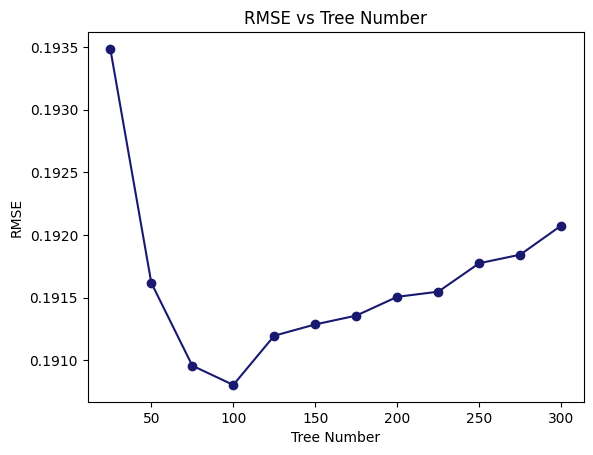

In [93]:
plt.plot(tree_range, rmse_outputs, 'o-', color='midnightblue')
plt.title('RMSE vs Tree Number')
plt.xlabel('Tree Number')
plt.ylabel('RMSE')

In [133]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 6  # maximum depth of a tree
param['subsample']        = 1 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# L2 regularization
param['lambda'] = 3

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

## Training

In [134]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [135]:
print(booster.eval(eval))

[0]	eval-rmse:0.19158690720646554	eval-rmse:0.19158690720646554	eval-rmse:0.19158690720646554


In [136]:
print(booster.eval(test))

[0]	eval-rmse:0.19137063165615154	eval-rmse:0.19137063165615154	eval-rmse:0.19137063165615154


In [137]:
predictions = booster.predict(test)

In [138]:
att = booster.attributes()

In [139]:
booster_df = booster.trees_to_dataframe()

In [154]:
booster_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,reco_g_1,0.161528,0-1,0-2,0-1,91963.328100,52500.000000,NaN
1,0,1,0-1,reco_g_2,0.573070,0-3,0-4,0-3,5965.527340,15070.000000,NaN
2,0,2,0-2,jj_m,100.806503,0-5,0-6,0-5,27453.687500,37430.000000,NaN
3,0,3,0-3,jj_m,109.245499,0-7,0-8,0-7,1973.683590,13684.250000,NaN
4,0,4,0-4,jj_m,108.802994,0-9,0-10,0-9,2883.485350,1385.750000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11263,99,122,99-122,Leaf,NaN,NaN,NaN,NaN,-0.079223,22.923649,NaN
11264,99,123,99-123,Leaf,NaN,NaN,NaN,NaN,0.006758,414.070587,NaN
11265,99,124,99-124,Leaf,NaN,NaN,NaN,NaN,0.061506,62.628323,NaN
11266,99,125,99-125,Leaf,NaN,NaN,NaN,NaN,-0.012408,655.713074,NaN


In [140]:
best_tree = booster.best_iteration

In [141]:
print(best_tree)

99


In [142]:
mass_only = booster_df[booster_df['Feature'] == 'jj_m']

In [159]:
mass_only

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
2,0,2,0-2,jj_m,100.806503,0-5,0-6,0-5,27453.687500,37430.000000,NaN
3,0,3,0-3,jj_m,109.245499,0-7,0-8,0-7,1973.683590,13684.250000,NaN
4,0,4,0-4,jj_m,108.802994,0-9,0-10,0-9,2883.485350,1385.750000,NaN
9,0,9,0-9,jj_m,100.833000,0-19,0-20,0-19,63.336182,375.000000,NaN
25,0,25,0-25,jj_m,94.910645,0-51,0-52,0-51,78.479980,2387.750000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11185,99,44,99-44,jj_m,124.710495,99-89,99-90,99-89,1.362098,8.107288,NaN
11188,99,47,99-47,jj_m,93.440704,99-95,99-96,99-95,8.371903,220.658188,NaN
11193,99,52,99-52,jj_m,122.223503,99-105,99-106,99-105,2.353346,13.080530,NaN
11195,99,54,99-54,jj_m,125.209000,99-109,99-110,99-109,1.604050,64.432617,NaN


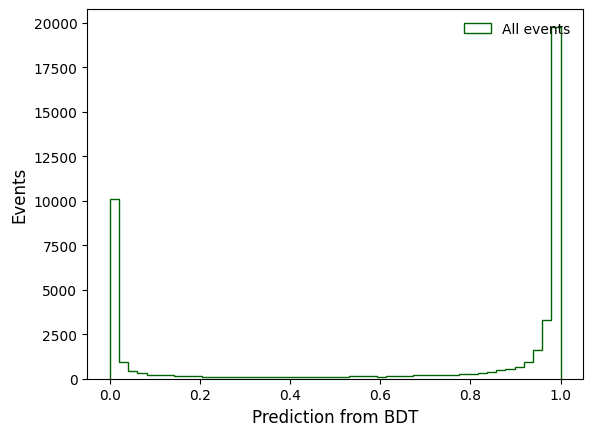

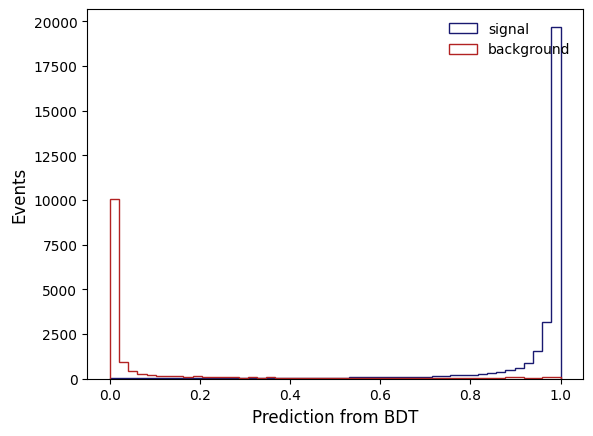

In [144]:
# plot all predictions (both signal and background)
plt.figure()
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

# plot signal and background separately
plt.figure()
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal')
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

/Users/nicktaylor/PycharmProjects/pythonProject/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


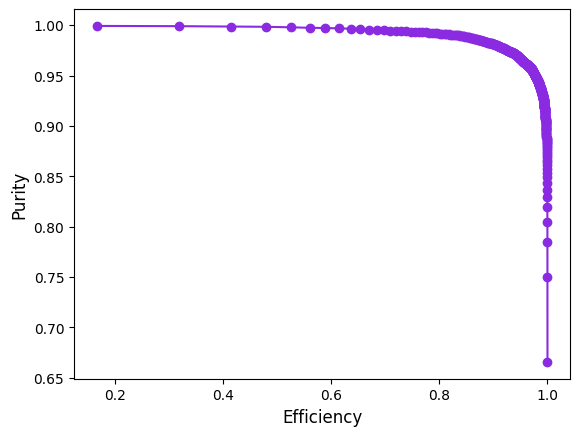

In [145]:
# choose score cuts:
cuts = np.linspace(0,1,500)
nsignal = np.zeros(len(cuts))
nbackground = np.zeros(len(cuts))
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0])
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0])

# plot efficiency vs. purity (ROC curve)
plt.figure()
plt.plot(nsignal/len(test_set[test_set.label == 1]),nsignal/(nsignal + nbackground),'o-',color='blueviolet')
# make the plot readable
plt.xlabel('Efficiency',fontsize=12)
plt.ylabel('Purity',fontsize=12)
plt.legend(frameon=False)

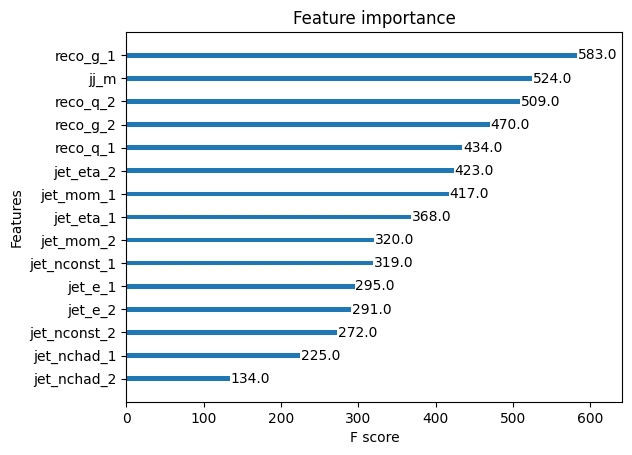

In [146]:
xgb.plot_importance(booster,grid=False);

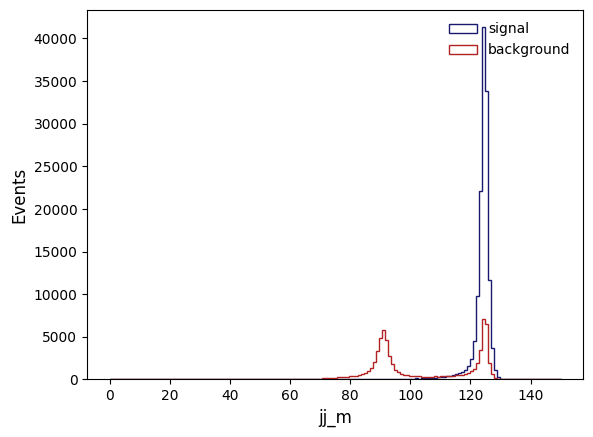

In [167]:
plt.figure()
plt.hist(training_set.jj_m[training_set.label == 1],bins=np.linspace(0,150,150),
         histtype='step',color='midnightblue',label='signal')
plt.hist(training_set.jj_m[training_set.label == 0],bins=np.linspace(0,150,150),
         histtype='step',color='firebrick',label='background')

plt.xlabel('jj_m',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

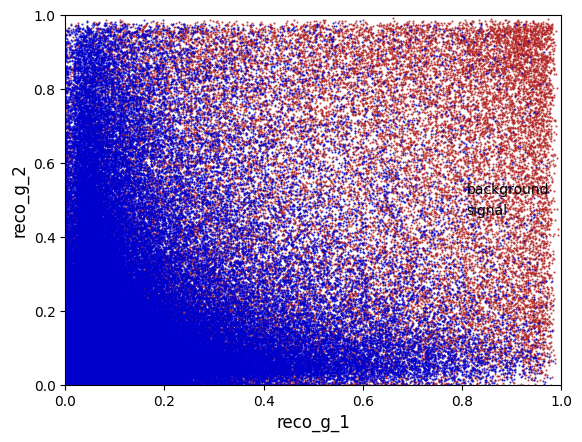

In [168]:
plt.figure()
plt.plot(training_set.reco_q_1[training_set.label == 0],training_set.reco_q_2[training_set.label == 0],
         'o',markersize=1.5,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.reco_q_1[training_set.label == 1],training_set.reco_q_2[training_set.label == 1],
         'o',markersize=1.5,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=2)

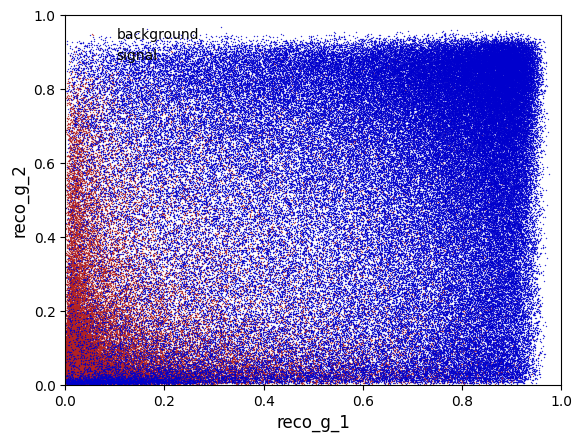

In [169]:
plt.figure()
plt.plot(training_set.reco_g_1[training_set.label == 0],training_set.reco_g_2[training_set.label == 0],
         'o',markersize=1,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.reco_g_1[training_set.label == 1],training_set.reco_g_2[training_set.label == 1],
         'o',markersize=1,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=1)

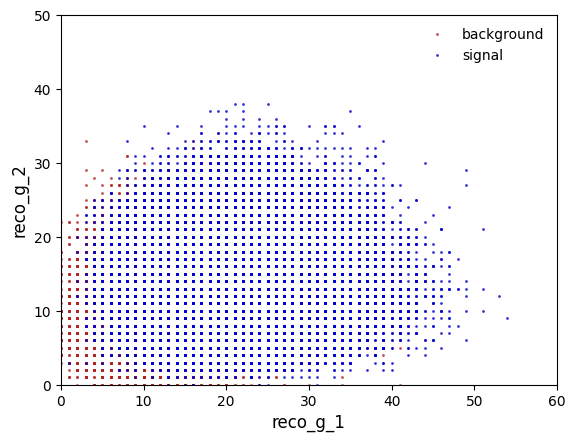

In [170]:
plt.figure()
plt.plot(training_set.jet_nchad_1[training_set.label == 0],training_set.jet_nchad_2[training_set.label == 0],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.jet_nchad_1[training_set.label == 1],training_set.jet_nchad_2[training_set.label == 1],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0, 60)
plt.ylim(0, 50)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=1)